In [27]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from sklearn.manifold import TSNE
import numpy as np
import random
import datasets

In [28]:
ds = datasets.load_dataset("damlab/uniprot")
ds["train"]["sequence"][0] # Inspect the sequence data

Found cached dataset parquet (/Users/josephboktor/.cache/huggingface/datasets/damlab___parquet/damlab--uniprot-28c00e1433a53e45/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


'MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLDAKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHLEKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDDSFRKIYTDLGWKFTPL'

Randomly suffle protein sequences

In [29]:
len(ds["train"]["sequence"]) #566996
prot_train = random.sample(ds["train"]["sequence"], 200000)

In [30]:
chars = sorted(list(set("".join(prot_train))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 0: '.'}


The following code is modeled from recitation 

In [31]:
context_length = 5
def make_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * context_length
        for ch in w + ".":
            X.append(context)
            y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, y = torch.tensor(X), torch.tensor(y)
    return X, y


In [32]:
trl = len(prot_train)
Xtr, ytr = make_dataset(prot_train[:int(0.9*trl)])
Xte, yte = make_dataset(prot_train[int(.9*trl):int(.95*trl)])
Xdev, ydev = make_dataset(prot_train[int(0.95*trl):])

In [33]:
class Model1(nn.Module):
    def __init__(self, embd_dim):
        super().__init__()
        self.inp_dim = embd_dim * context_length
        self.C = nn.Embedding(len(itos), embd_dim)
        
        self.fc1 = nn.Linear(self.inp_dim, 4 * self.inp_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * self.inp_dim, self.inp_dim)
        self.fc3 = nn.Linear(self.inp_dim, len(itos))
        
    def forward(self, ix):
        x = self.C(ix).view(-1, self.inp_dim) # 16 * 5
        
        h = self.fc1(x)
        h = self.gelu(h)
        h = self.fc2(h)
        h = self.gelu(h)
        h = self.fc3(h)
        return h

In [34]:
model = Model1(16)

In [35]:
# Training loop
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = []

for step in range(10000):
    optimizer.zero_grad()
    ix = torch.randint(0, Xtr.shape[0], (32,))
    logits = model(Xtr[ix])
    loss = F.cross_entropy(logits, ytr[ix])
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if step % 1000 == 0:
        print(f"{step=}, {loss=}")

step=0, loss=tensor(3.2683, grad_fn=<NllLossBackward0>)
step=1000, loss=tensor(2.9651, grad_fn=<NllLossBackward0>)
step=2000, loss=tensor(3.0449, grad_fn=<NllLossBackward0>)
step=3000, loss=tensor(2.7313, grad_fn=<NllLossBackward0>)
step=4000, loss=tensor(2.8965, grad_fn=<NllLossBackward0>)
step=5000, loss=tensor(2.8336, grad_fn=<NllLossBackward0>)
step=6000, loss=tensor(2.9073, grad_fn=<NllLossBackward0>)
step=7000, loss=tensor(2.9040, grad_fn=<NllLossBackward0>)
step=8000, loss=tensor(2.7450, grad_fn=<NllLossBackward0>)
step=9000, loss=tensor(2.8168, grad_fn=<NllLossBackward0>)


Visualizing model performance

In [36]:
weight = next(model.named_parameters())[1].detach().numpy()

In [37]:
norm = np.linalg.norm(weight, axis=1)
norm_matrix = norm[:, None] * norm[None, :]
cosin_distance = (weight @ weight.T) / norm_matrix

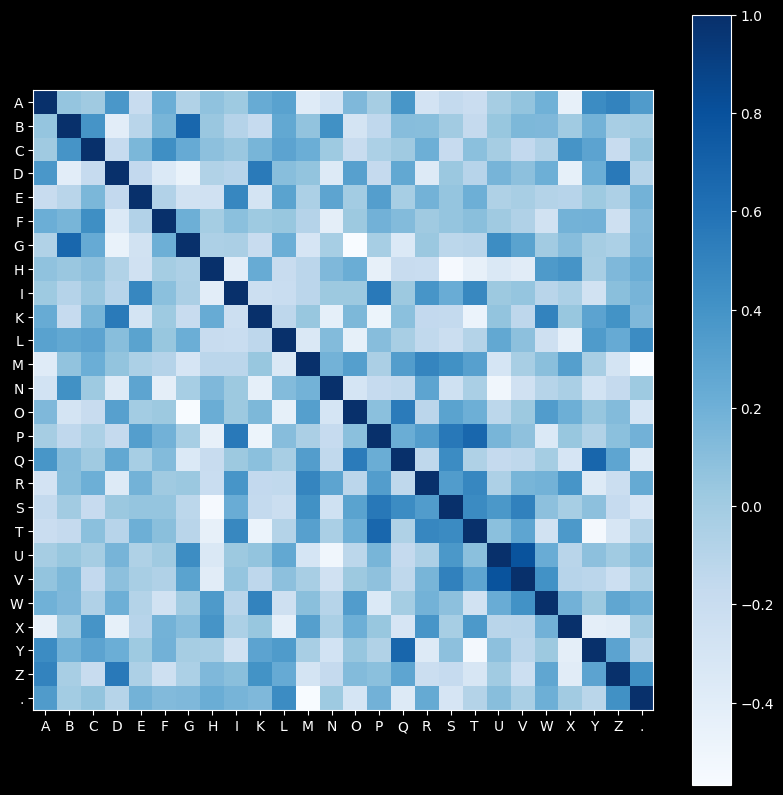

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(cosin_distance, cmap="Blues")
plt.colorbar()
plt.xticks(np.arange(len(itos)), labels=list(itos.values()));
plt.yticks(np.arange(len(itos)), labels=list(itos.values()));

In [39]:
pca = PCA(n_components=2)
vis = pca.fit_transform(weight)

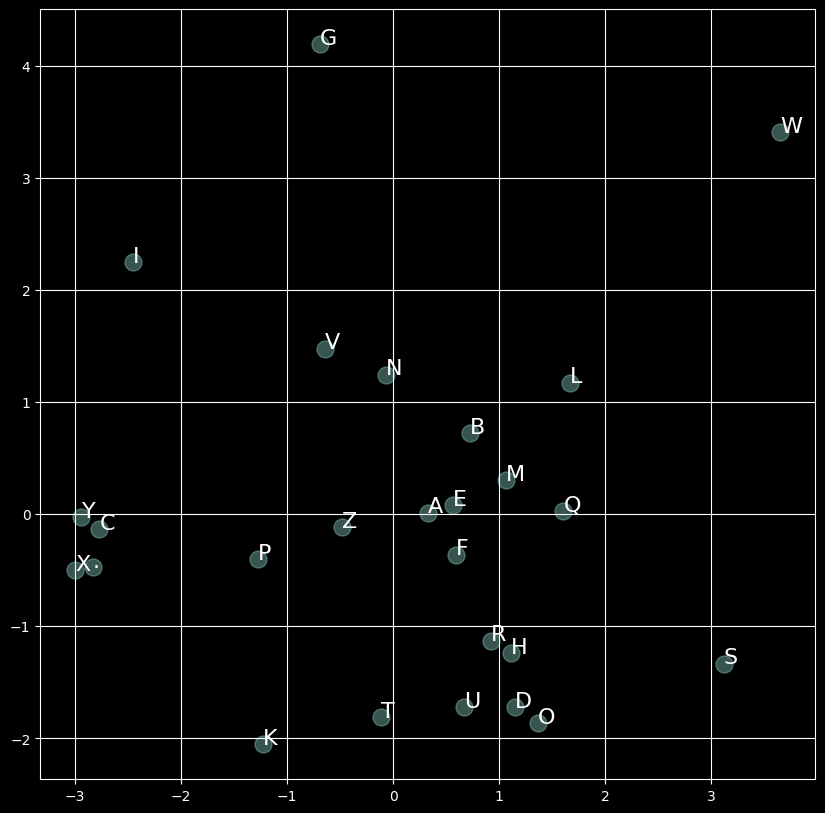

In [50]:
plt.figure(figsize=(10,10))
plt.scatter(vis[:, 0], vis[:, 1], s=150, alpha=0.4)
plt.grid(True)

for ix, char in itos.items():
    plt.annotate(char, vis[ix], fontsize=16)
plt.savefig('figname.png')